##### Queremos implementar un sistema que sea capaz de detectar automáticamente si una página web contiene spam o no basándonos en su URL.

In [1]:
# Cargar datos
import pandas as pd

url = 'https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv'
dataset = pd.read_csv(url)

In [2]:
dataset.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [3]:
dataset.shape

(2999, 2)

In [4]:
dataset.is_spam.unique()

array([ True, False])

In [5]:
#Cambiar True y False por valores numericos

mapeo = {True:1, False:0}

dataset['is_spam'] = dataset['is_spam'].map(mapeo)

dataset.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


In [6]:
#Se eiminan duplicados

print(f'Registros iniciales {dataset.shape[0]}')

dataset.drop_duplicates(inplace=True)

print(f'Registros luego de eliminar duplicados {dataset.shape[0]}')

Registros iniciales 2999
Registros luego de eliminar duplicados 2369


In [7]:
print(dataset.shape)
print(f"Spam: {len(dataset.loc[dataset.is_spam == 1])}")
print(f"No Spam: {len(dataset.loc[dataset.is_spam == 0])}")

(2369, 2)
Spam: 244
No Spam: 2125


Limpieza de la columna url

In [10]:
import regex as re

def preprocess_text(text):
    # Eliminar cualquier caracter que no sea una letra (a-z) o un espacio en blanco ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Eliminar espacios en blanco
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Reducir espacios en blanco múltiples a uno único
    text = re.sub(r'\s+', " ", text.lower())

    # Eliminar tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

dataset["url"] = dataset["url"].apply(preprocess_text)
dataset.head()

,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1


In [12]:
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

dataset["url"] = dataset["url"].apply(lemmatize_text)
dataset.head()

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1


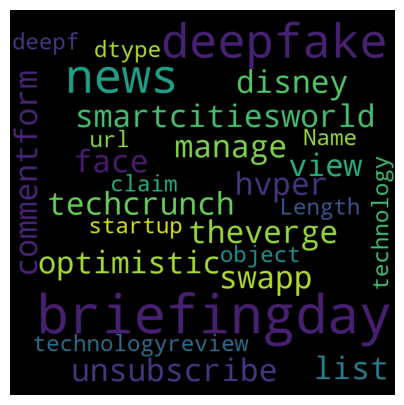

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(dataset["url"]))

fig = plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens_list = dataset["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = dataset["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [20]:
from sklearn.svm import SVC

model_base = SVC(random_state = 42)

In [22]:
model_base.fit(X_train, y_train)

SVC(random_state=42)

In [24]:
y_predict_base = model_base.predict(X_test)

In [26]:
from sklearn.metrics import accuracy_score

print(f'El rendimiento base fue de {round(accuracy_score(y_test, y_predict_base),5)}')

El rendimiento base fue de 0.96203


Se intentará mejorar el rendimiento, mediante la variación de hiperparámetros.